## 01 Loan By Country Exploration
We are going to start with the big *kiva_loans.csv* file. Let's see what we an quickly learn on the countries, number of loans, type of needs, etc...

### Loans by countries and population

To get more detailed information per country, we need to get additional informations such as population. We use the Wikipedia population data updated on the 1st of January 2019. A bit of preprocessing is necessary after a simple copy-paste of the table.

The following line helps preparing the table copy-pasted from Wikipedia website.
*cat wiki_pop.tmp | sed 's/,//g' | awk -F $'\t' 'BEGIN {OFS=FS} {print $2 "," $3}' | sed 's/(.*)//g' | sed 's/\[.*\]//g' > wiki_pop_tmp.csv*
Following it, a little manual posttreatment is needed to finish (especially "Flag of ..." appearing here and there).

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Adding a bit of postprocessing by taking off space before and after the country name
with open("data/02-kiva/wiki_pop_tmp.csv","rt") as instream:
    with open("data/02-kiva/wiki_pop_tmp2.csv","wt") as outstream:
        for line in instream:
            sen = line.split(",")
            outstream.write("{},{}".format(sen[0].lstrip().rstrip(),sen[1]))

In [3]:
def total_loan_stats(kldf,population_df,label="population"):
    country_df = pd.DataFrame(columns=["country","loan_by_country","nb_loan_by_country","population",
                                   "loan_by_country_norm","nb_loan_by_country_norm"])
    country_df["country"] = kldf.country.unique()
    country_df.set_index("country",inplace=True)
    for country in kldf.country.unique():
        mask = kldf.country == country
        country_df.at[country,"loan_by_country"] = np.sum(kldf.loan_amount[mask])
        country_df.at[country,"nb_loan_by_country"] = np.sum(mask)
        if country in population_df.index:
            population = country_df.at[country,"population"] = population_df.loc[country,label]
            country_df.at[country,"loan_by_country_norm"] = country_df.at[country,"loan_by_country"] / population
            country_df.at[country,"nb_loan_by_country_norm"] = country_df.at[country,"nb_loan_by_country"] / population
        else:
            print("Warning: no population information on country: {}".format(country))
    return country_df

kldf = pd.read_csv("data/02-kiva/kiva_loans.csv",index_col=0)
wiki_population_df = pd.read_csv("data/02-kiva/wiki_pop_tmp2.csv",index_col=0)
country_df = total_loan_stats(kldf,wiki_population_df)

Still a lot of miss. We matched the missing names Kiva's and saved it in *wiki_pop.csv*

In [4]:
wiki_population_df = pd.read_csv("data/02-kiva/wiki_pop.csv",index_col=0)
country_df = total_loan_stats(kldf,wiki_population_df)
country_df.to_csv("data/02-kiva/country_loan.csv")

Now for some statistics. Let's find which countries get more or less loan.

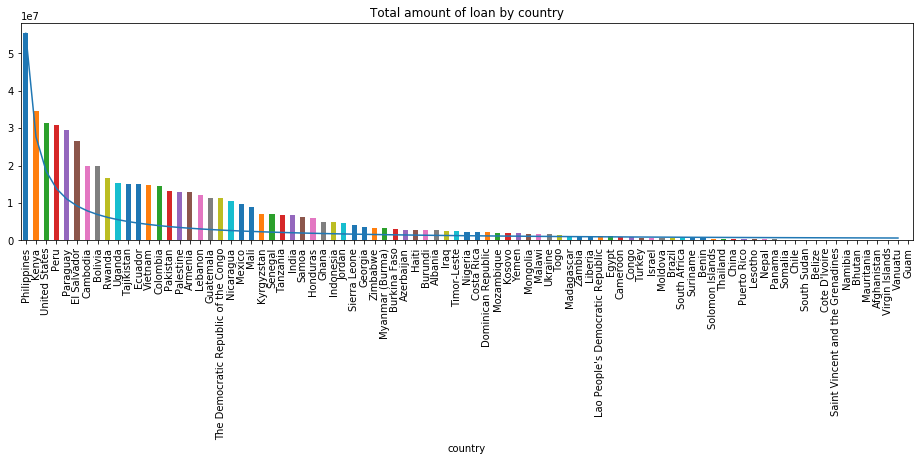

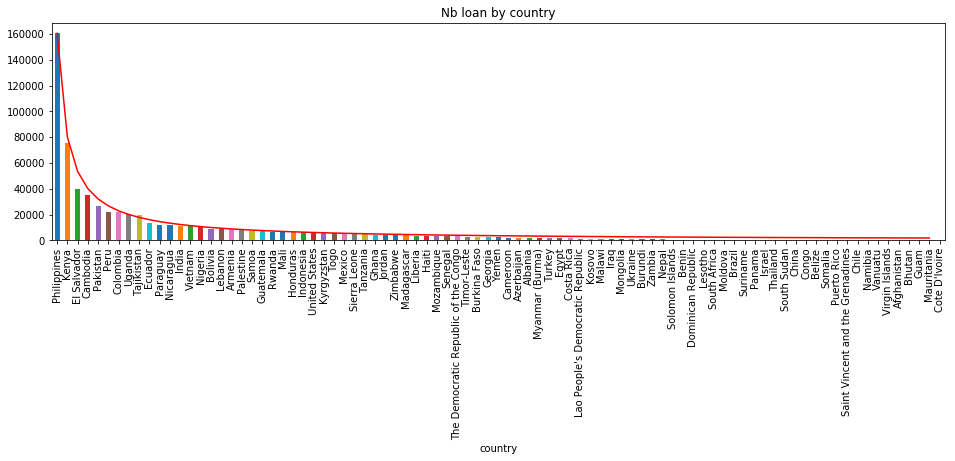

In [22]:
country_by_loan_df = country_df.sort_values(by="loan_by_country",ascending=False)
country_by_nb_loan_df = country_df.sort_values(by="nb_loan_by_country",ascending=False)
plt.figure(figsize=(16,4))
country_by_loan_df["loan_by_country"].plot(kind="bar",title="Total amount of loan by country")
zipf_x = np.arange(1.,country_df.shape[0])
zipf_y = 1./zipf_x
plt.plot(zipf_x-1,zipf_y*country_df["loan_by_country"].max())
plt.figure(figsize=(16,4))
country_by_nb_loan_df["nb_loan_by_country"].plot(kind="bar",title="Nb loan by country")
plt.plot(zipf_x-1,zipf_y*country_df["nb_loan_by_country"].max(),color="red")

Note how the number of loan per country seems to perfectly match **Zipf's law**.

There is a big amount of money and number of loans going into the Philipines. To give a proper value to this, let's see what the numbers are for the top 10 and bottom 10.

In [6]:
print("Countries receiving more loans by value")
print(country_by_loan_df["loan_by_country"].head(10))
print("\nCountries receiving highest number of loans")
print(country_by_nb_loan_df["nb_loan_by_country"].head(10))
print("\nCountries receiving the least of loans by value")
print(country_df.sort_values(by="loan_by_country",ascending=True)["loan_by_country"].head(10))
print("\nCountries receiving the least number of loans")
print(country_df.sort_values(by="nb_loan_by_country",ascending=True)["nb_loan_by_country"].head(10))

Countries receiving more loans by value
country
Philippines      5.53422e+07
Kenya            3.45343e+07
United States    3.14964e+07
Peru             3.08674e+07
Paraguay         2.96291e+07
El Salvador      2.66036e+07
Cambodia         1.98727e+07
Bolivia          1.98432e+07
Rwanda           1.66463e+07
Uganda           1.53894e+07
Name: loan_by_country, dtype: object

Countries receiving highest number of loans
country
Philippines    160441
Kenya           75825
El Salvador     39875
Cambodia        34836
Pakistan        26857
Peru            22233
Colombia        21995
Uganda          20601
Tajikistan      19580
Ecuador         13521
Name: nb_loan_by_country, dtype: object

Countries receiving the least of loans by value
country
Guam                                  4300
Vanuatu                               9250
Virgin Islands                       10000
Afghanistan                          14000
Mauritania                           15000
Bhutan                               200

First, it's interesting to see the Zipf's law applying to the first few values.
The number and total value of loan given to the Philipines looks abnormally high compared to every other country. Let's see what happens if we normalize these numbers by population size.

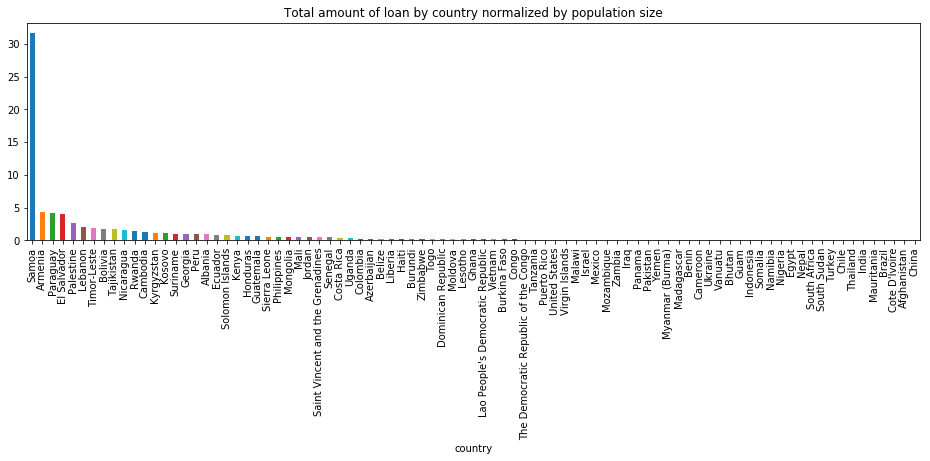

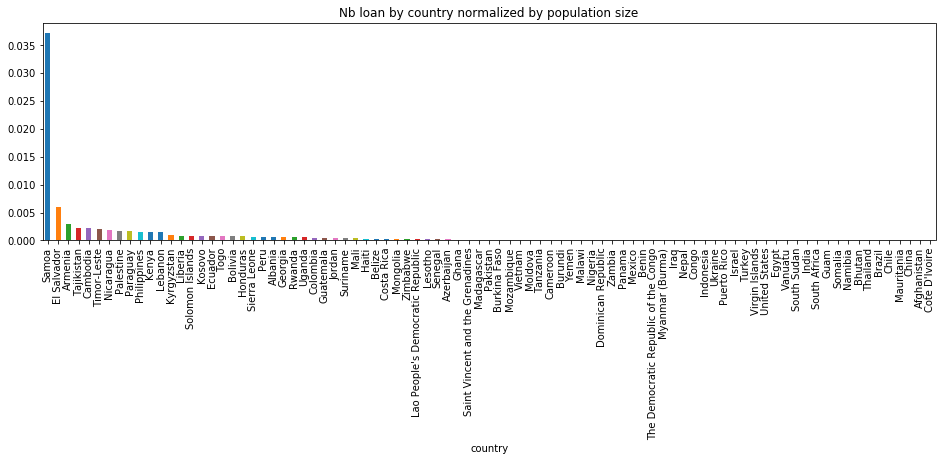

In [7]:
country_by_loan_norm_df = country_df.sort_values(by="loan_by_country_norm",ascending=False)
country_by_nb_loan_norm_df = country_df.sort_values(by="nb_loan_by_country_norm",ascending=False)
plt.figure(figsize=(16,4))
country_by_loan_norm_df["loan_by_country_norm"].plot(kind="bar",title="Total amount of loan by country normalized by population size")
plt.figure(figsize=(16,4))
country_by_nb_loan_norm_df["nb_loan_by_country_norm"].plot(kind="bar",title="Nb loan by country normalized by population size")

Now the Philipines look more "in the mix" while Samoa become our outsider. Let's take a look at Samoa in particular.

In [8]:
country_df.loc["Samoa"]

loan_by_country            6.29158e+06
nb_loan_by_country                7396
population                      199052
loan_by_country_norm           31.6077
nb_loan_by_country_norm      0.0371561
Name: Samoa, dtype: object